# Assignment 1

## Step 1: Uploading and inspecting the data

* `head()` for getting a first few rows of the dataset, looking at the kind of values
* `info()` for getting the description of the data columns
* `value_counts()` for counting the instances of each value in categorical variable (maybe would work for floating-point but results would be rather meaningless).
* `describe()` for per-feature summary statistics

*Questions on interpretation of the dataset from* `describe()`:
1. *Interpreting the values.* Not sure what is meant there. The method just returns per-column (feature) summary statistics.
2. *Meaning of percentiles.* Percentiles tell how much the distribution is skewed based on how far away the median is from each of the quartiles—`households` column is one such example where distribution is skewed to the left (or tail-heavy?).
3. *Handling of missing values.* Documentation says `NaN` by default, which would be skipped in computing statistics (`skipna=True` by default) but would be kept in arrays and propagate through arithmetic calculations. When all values are `NaN` result in automatic statistic calculation is 0.

## Step 2: Splitting the data into training and test sets

* `np.random.permutation(len(data))` for shuffling the indices and then taking `test_indices` and `train_indices` from this accordingly;
  * `data.iloc[train_indices]` for retrieving the data
* `from sklearn.model_selection import train_test_split` for automatically splitting the dataset by describing the fraction of test data
* stratified sampling to get similar train and test distributions if some features are imbalanced—both distributions will be more representative
* binning to limit the number of strata
  * `from sklearn.model_selection import StratifiedShuffleSplit`
  * split based on a categorical attribute: `split.split(df, df["attr"])`
  
## Step 3: Exploring the attributes

* Visualisation to 
  * see most informative attributes 
  * observe correlations with target label using scatter matrix
  * observe the need for normalisation/scaling
  * can also indicate the artifacts in the data that would need cleaning up
* Create extra features

## Step 4: Data preparation and transformations of machine learning algorithms

Required for:
* handling missing values (if any)
  * `from sklearn.impute import SimpleImputer`, `imputer.fit(df)`, `imputer.transform`
* converting attribute values into numerical format (e.g. transform categorical data into numbers)—*is this actually needed? and it doesn't really make sense for a regression task anyway, especially if there is no 'increasing' ordering to categories*
  * numeric value makes the least sense but one-hot encoding using `sklearn.preprocessing.OneHotEncoder`+`sklearn.preprocessing.LabelBinarizer` is better
* scaling or normalising data
* data transformers and pipelines for connecting transformations together with `fit`/`transform`/`fit_transform`
* `FeatureUnion` for connecting together several pipelines (one for each type of feature of categorical/numerical


## Step 5: Implementation, evaluation and fine-tuning of a regression model

* training, testing, cross-validation—the usual.

# Task 2: Experimenting with different steps in the ML pipeline

First implement the base of the ML pipeline.

In [1]:
import pandas as pd
import numpy as np
import os
%matplotlib inline 
#so that the plot will be displayed in the notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm

np.random.seed(42)

In [2]:
# loading data
def load_data(housing_path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_data("housing/")

In [3]:
# stratifying dataset
from sklearn.model_selection import StratifiedShuffleSplit

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace = True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [4]:
# split training data from labels
housing = strat_train_set.drop("median_house_value", axis=1) # inplace=False
housing_labels = strat_train_set["median_house_value"].copy() 

In [5]:
# adding derived features (not used for Task 2.1)
def add_features(data):
    # add the transformed features that you found useful before
    data["rooms_per_household"] = data["total_rooms"] / data["households"]
    data["bedrooms_per_household"] = data["total_bedrooms"] / data["households"]
    data["bedrooms_per_rooms"] = data["total_bedrooms"] / data["total_rooms"]
    data["population_per_household"] = data["population"] / data["households"]   
    
add_features(housing)

For Task 2.1, run the cells in the [section below](#2.1) before continuing.]

In [6]:
# handling missing values (not used for Task 2.2)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

For Task 2.2, run one of the cells in the section below before continuing.

In [7]:
# handling textual and categorical attributes
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing["ocean_proximity"])

In [8]:
# data transformation
from sklearn.base import TransformerMixin # TransformerMixin allows you to use fit_transform method
from sklearn.base import BaseEstimator
# BaseEstimator allows you to drop *args and **kwargs from you constructor
# and, in addition, allows you to use methods set_params() and get_params()


class CustomLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, X, y=0):
        self.encoder.fit(X)
        return self
    def transform(self, X, y=0):
        return self.encoder.transform(X)
    

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
    
rooms_id, bedrooms_id, population_id, household_id = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_rooms = True): # note no *args and **kwargs used this time
        self.add_bedrooms_per_rooms = add_bedrooms_per_rooms
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_id] / X[:, household_id]
        bedrooms_per_household = X[:, bedrooms_id] / X[:, household_id]
        population_per_household = X[:, population_id] / X[:, household_id]
        if self.add_bedrooms_per_rooms:
            bedrooms_per_rooms = X[:, bedrooms_id] / X[:, rooms_id]
            return np.c_[X, rooms_per_household, bedrooms_per_household, 
                         population_per_household, bedrooms_per_rooms]
        else:
            return np.c_[X, rooms_per_household, bedrooms_per_household, 
                         population_per_household]

Skip the cell below for Task 2.1

In [9]:
attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing.values)

housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+
                                     ["rooms_per_household", "bedrooms_per_household", 
                                      "population_per_household", "bedrooms_per_rooms"])

In [10]:
# feature scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
housing_tr_scaled = scaler.fit_transform(housing_tr)

In [11]:
list(housing_num)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'income_cat',
 'rooms_per_household',
 'bedrooms_per_household',
 'bedrooms_per_rooms',
 'population_per_household']

In [13]:
# pipeline
from sklearn.pipeline import Pipeline, FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', CustomLabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


housing = strat_train_set.drop("median_house_value", axis=1)
housing = housing.reindex(columns=list(housing.columns) + ["ocean_proximity", 'rooms_per_household', 'population_per_household', 'bedrooms_per_rooms', 'bedrooms_per_household'])
housing_labels = strat_train_set["median_house_value"].copy()

housing_prepared = full_pipeline.fit_transform(housing)

ValueError: Multioutput target data is not supported with label binarization

In [ ]:
housing_prepared.shape

In [ ]:
# training
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
# loss
from sklearn.metrics import mean_squared_error

# RMSE
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression())])

model = model.fit(housing_prepared, housing_labels)
housing_predictions = model.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
# desision tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg = tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_mse = np.sqrt(tree_mse)
tree_mse

In [ ]:
# cross-validation
from sklearn.model_selection import cross_val_score
    
def analyse_cv(model):   
    scores = cross_val_score(model, housing_prepared, housing_labels,
                             scoring = "neg_mean_squared_error", cv=10)

    # cross-validation expects utility function (greater is better)
    # rather than cost function (lower is better), so the scores returned
    # are negative as they are the opposite of MSE
    sqrt_scores = np.sqrt(-scores) 
    print("Scores:", sqrt_scores)
    print("Mean:", sqrt_scores.mean())
    print("Standard deviation:", sqrt_scores.std())
    
analyse_cv(tree_reg)

In [ ]:
analyse_cv(lin_reg)

In [ ]:
# random forest
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10)
analyse_cv(forest_reg)

## `RandomizedSearchCV`

In [ ]:
# fine-tuning
from sklearn.model_selection import GridSearchCV

# specify the range of hyperparameter values for the grid search to try out 
param_grid = {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_

## Adjusting feature importance weights

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ['rooms_per_household', 'bedrooms_per_household', 'population_per_household', 'bedrooms_per_rooms']
cat_one_hot_attribs = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
attributes = num_attribs + extra_attribs + cat_one_hot_attribs # Remove extra_attribs for Task 2.1
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
# evaluating best model in grid search
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

## Evaluating performance of simple linear regression

## 2.1 Dropping less informative features
<a id='2.1'></a>

Instead of adding features with `add_features`, we derive a method for removing less informative features.

From the correlation matrix other data analysis, we can try removing features that correlate the least with the label (correlation is closest to 0). Here I set the threshold for removing the feature at `corr` $\leq 0.1$.

In [ ]:
def drop_uncorrelated_features(housing, housing_labels, threshold=0.1, inplace=False):
    corr_matrix = housing.corrwith(housing_labels)
    result = housing.copy()
    for feature_name in corr_matrix.keys():
        if abs(corr_matrix[feature_name]) <= threshold:
            result = result.drop(feature_name, axis=1, inplace=inplace)
    return result

In [ ]:
housing_less_features = drop_uncorrelated_features(housing, housing_labels)

housing_less_features.info()

Training the linear regression model: set `housing` to `housing_less_features` and run the cells for training again.

In [ ]:
housing = housing_less_features

Running the appropriate cells above returns the following:
* linear regression RMSE loss on training set: 
```
73093.17121767759
```
* polynomial features RMSE loss on training set:
```
66716.81
```
* descision tree regression cv scores: 
```
Scores: [84032.49004171 83383.91403853 86911.25618704 84979.91760443
 83318.48233598 87035.75651828 81730.25765011 87262.51548502
 90687.78902004 81905.17420337]
Mean: 85124.75530845068
Standard deviation: 2678.7378046054023
```
* linear regression cv scores:
```
Scores: [71582.79797914 71558.92841559 72016.97250802 74659.07214991
 72930.82717259 75799.57809476 69539.81669857 72886.06082662
 76948.76494249 73291.86027004]
Mean: 73121.46790577391
Standard deviation: 2077.562701780748
```
* random forest cv scores:
```
Scores: [62904.45963636 63743.90193276 66368.02660397 66220.97112199
 65251.3907331  67133.70330807 62868.39284466 65963.95283889
 68337.41046908 66190.1122955 ]
Mean: 65498.2321784392
Standard deviation: 1717.3381486078756
```
* final rmse:
```
61577.52437907747
```

The errors can be plotted as follows

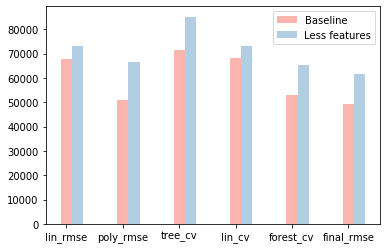

In [14]:
baseline = {"lin_rmse": 67912.11389345869, 
                   "poly_rmse": 50845.991750972935, 
                   "tree_cv": 71398.43250937833, 
                   "lin_cv": 68193.13973080671, 
                   "forest_cv": 52833.36700903783, 
                   "final_rmse": 49109.221590658875
                  }
less_features = {"lin_rmse": 73093.17, 
                   "poly_rmse": 66716.81, 
                   "tree_cv": 85124.76, 
                   "lin_cv": 73121.47, 
                   "forest_cv": 65498.23, 
                   "final_rmse": 61577.52
                  }

X = np.arange(len(baseline))
ax = plt.subplot(111)
ax.bar(X, baseline.values(), width=0.2, align='center', color=cm.Pastel1(0))
ax.bar(X+0.2, less_features.values(), width=0.2, align='center', color=cm.Pastel1(1))
ax.legend(('Baseline','Less features'))
plt.xticks(X, baseline.keys())
plt.show()

So in all cases the dropped features resulted in higher accuracy error when cross validation threshold was 0.1. Choosing a smaller threshold of 0.05 we get:

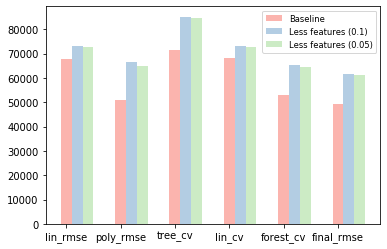

In [15]:
less_features2 = {"lin_rmse": 72528.01, 
                   "poly_rmse": 65024.48, 
                   "tree_cv": 84517.32, 
                   "lin_cv": 72561.17, 
                   "forest_cv": 64665.28, 
                   "final_rmse": 61309.45
                  }

X = np.arange(len(baseline))
ax = plt.subplot(111)
ax.bar(X, baseline.values(), width=0.2, align='center', color=cm.Pastel1(0))
ax.bar(X+0.2, less_features.values(), width=0.2, align='center', color=cm.Pastel1(1))
ax.bar(X+0.4, less_features2.values(), width=0.2, align='center', color=cm.Pastel1(2))
ax.legend(('Baseline','Less features (0.1)', 'Less features (0.05)'), fontsize='small')
plt.xticks(X, baseline.keys())
plt.show()

This suggests that having less features does not help, especially when the features that were removed were the basis of derived features that were added to the original pipeline before prepropcessing (e.g. `households`, `total_bedrooms`).

## 2.2 Using alternative preprocessing options

### `SimpleImputer` strategies

In [55]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

# Task 3: Bike sharing dataset